<a href="https://colab.research.google.com/github/EugIva/ProzorovEI209M_CV/blob/main/HW4_Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача №1 - Хвост кита    

Не так давно на kaggle было соревнование по классификации горбатых китов по снимках их хвостов. Одним из приемов для улучшения работы нейронной сети было выделение маски хвоста. Затем по этой маске вырезался хвост на исходном изображении, нормировался, отображался на черный фон и подавался нейронной сети на вход.

Ваша задача - написать программу, которая совершит предобработку картинки, описанную выше. Т.е. найти маску хвоста, по маске вырезать из исходного изображения хвост, нормировать изображение хвоста так, чтобы оно всегда имело один заданный размер и равномерно занимало место, то есть, если хвост был повернут, его нужно выпрямить.

После выделения хвоста посчитайте IoU для каждой картинки (используя маски)

IoU   
Intercetion over union - число от 0 до 1, показывающее, насколько у двух объектов (эталонного (ground true) и текущего) совпадает внутренний “объем”.

In [20]:
import os
import cv2
import numpy as np
from skimage import transform
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt

In [21]:
def load_image_and_mask(image_path, mask_path):
    # Загрузка изображения и маски
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    return image, mask

def extract_tail(image, mask):
    # Поиск контуров на маске
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None
    # Нахождение самого большого контура
    largest_contour = max(contours, key=cv2.contourArea)
    # Получение ограничивающего прямоугольника для контура
    x, y, w, h = cv2.boundingRect(largest_contour)
    # Вырезание хвоста из изображения и маски
    tail = image[y:y+h, x:x+w]
    tail_mask = mask[y:y+h, x:x+w]
    return tail, tail_mask

def normalize_and_align_tail(tail, tail_mask, target_size=(128, 128)):
    # Поиск контуров на маске хвоста. функция возвращает как выровненное изображение хвоста, так и маску хвоста
    contours, _ = cv2.findContours(tail_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None
    # Нахождение самого большого контура
    largest_contour = max(contours, key=cv2.contourArea)
    # Определение эллипса, описывающего контур
    (x, y), (MA, ma), angle = cv2.fitEllipse(largest_contour)
    rows, cols, _ = tail.shape
    # Поворот изображения и маски хвоста
    M = cv2.getRotationMatrix2D((x, y), angle, 1)
    rotated_tail = cv2.warpAffine(tail, M, (cols, rows))
    rotated_tail_mask = cv2.warpAffine(tail_mask, M, (cols, rows))
    # Поиск контуров на повернутой маске хвоста
    contours, _ = cv2.findContours(rotated_tail_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None
    # Нахождение самого большого контура
    largest_contour = max(contours, key=cv2.contourArea)
    # Получение ограничивающего прямоугольника для контура
    x, y, w, h = cv2.boundingRect(largest_contour)
    # Вырезание выровненного хвоста из повернутого изображения и маски
    aligned_tail = rotated_tail[y:y+h, x:x+w]
    aligned_tail_mask = rotated_tail_mask[y:y+h, x:x+w]
    # Изменение размера выровненного хвоста и маски до целевого размера
    aligned_tail = cv2.resize(aligned_tail, target_size)
    aligned_tail_mask = cv2.resize(aligned_tail_mask, target_size)
    return aligned_tail, aligned_tail_mask

def calculate_iou(mask1, mask2):
    # Преобразование масок в бинарные массивы. принимает маски одинакового размера
    mask1 = mask1.flatten() > 0
    mask2 = mask2.flatten() > 0
    # Вычисление IoU
    return jaccard_score(mask1, mask2)

def visualize_images(image, mask, aligned_tail, aligned_tail_mask, resized_mask, filename):
    # Визуализация изображений и масок
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.contour(mask, colors='red')

    plt.subplot(1, 3, 2)
    plt.title('Aligned Tail')
    plt.imshow(cv2.cvtColor(aligned_tail, cv2.COLOR_BGR2RGB))
    plt.contour(aligned_tail_mask, colors='red')

    plt.subplot(1, 3, 3)
    plt.title('Resized Mask')
    plt.imshow(resized_mask, cmap='gray')

    plt.suptitle(f'Image: {filename}')
    plt.show()

def process_images(image_dir, target_size=(128, 128)):
  # Перед вычислением IoU маска оригинального изображения ресайзится до целевого размера
    iou_scores = []
    for filename in os.listdir(image_dir):
        if filename.startswith('test_image') and filename.endswith('.jpg'):
            image_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(image_dir, filename[:-4] + '.png')
            image, mask = load_image_and_mask(image_path, mask_path)
            tail, tail_mask = extract_tail(image, mask)
            if tail is not None and tail_mask is not None:
                aligned_tail, aligned_tail_mask = normalize_and_align_tail(tail, tail_mask, target_size)
                if aligned_tail is not None and aligned_tail_mask is not None:
                    # Изменение размера оригинальной маски до целевого размера
                    resized_mask = cv2.resize(mask, target_size)
                    iou = calculate_iou(resized_mask, aligned_tail_mask)
                    iou_scores.append(iou)
                    print(f'Image: {filename}, IoU: {iou}')
                    # Визуализация изображений и масок
                    visualize_images(image, mask, aligned_tail, aligned_tail_mask, resized_mask, filename)
    return iou_scores

Изображения хвостов я поместил в колабе в единую папку data и различаю их по расширению jpg. Разметки картинок (маски хвостов) лежат здесь же, имеют те же названия, но различаются по расширению .png.

Image: test_image_03.jpg, IoU: 0.17272518558200045


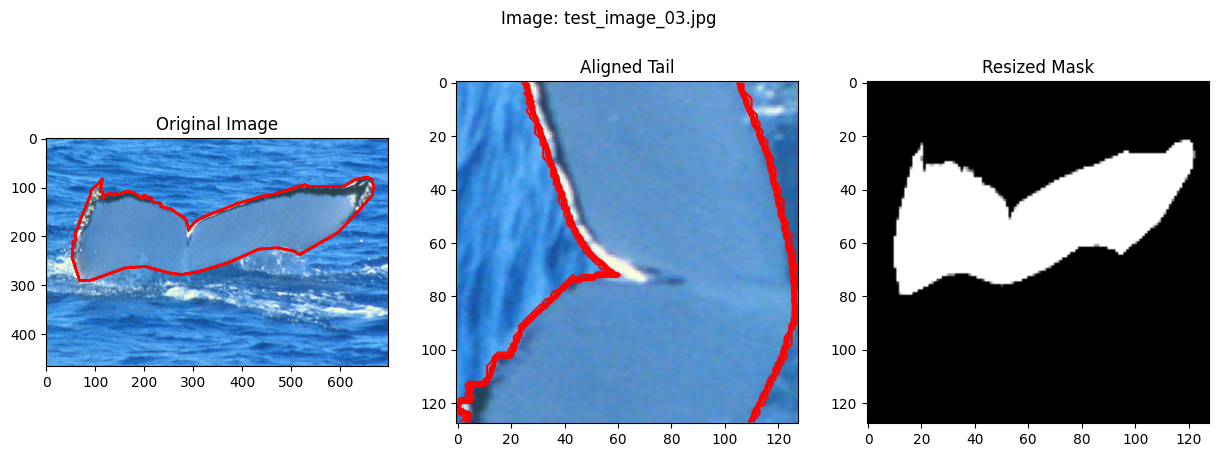

Image: test_image_10.jpg, IoU: 0.34478340940027224


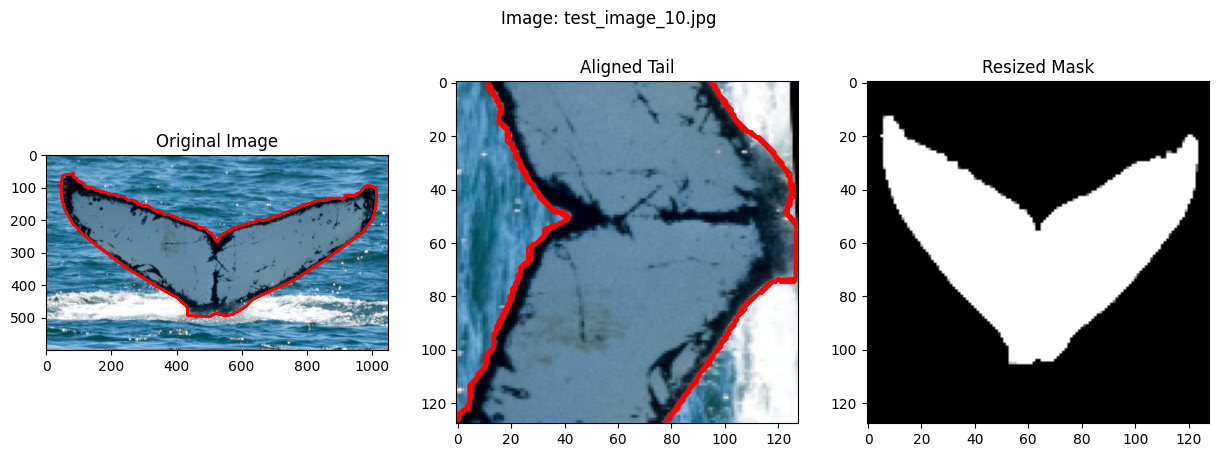

Image: test_image_00.jpg, IoU: 0.4005402971634399


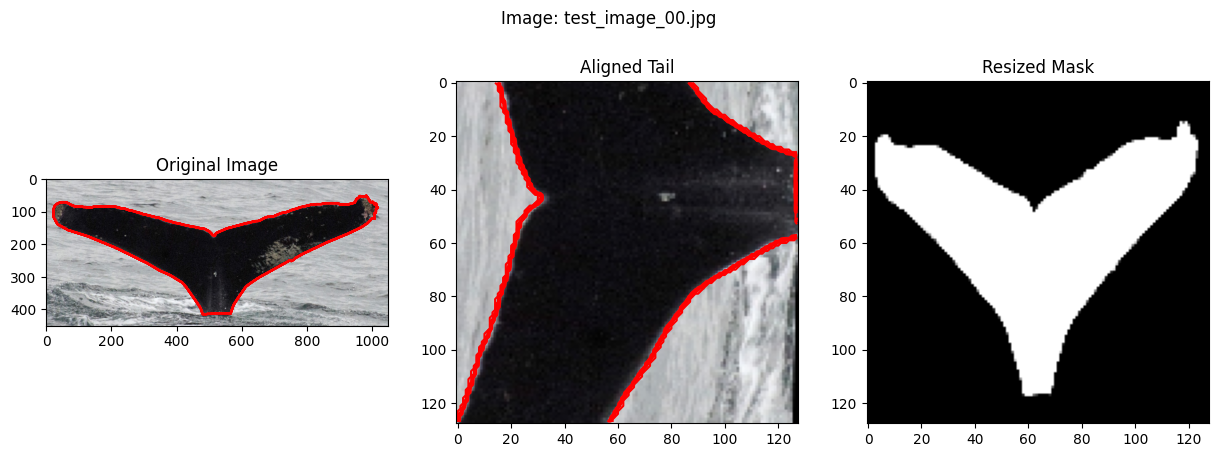

Image: test_image_02.jpg, IoU: 0.2489830378386676


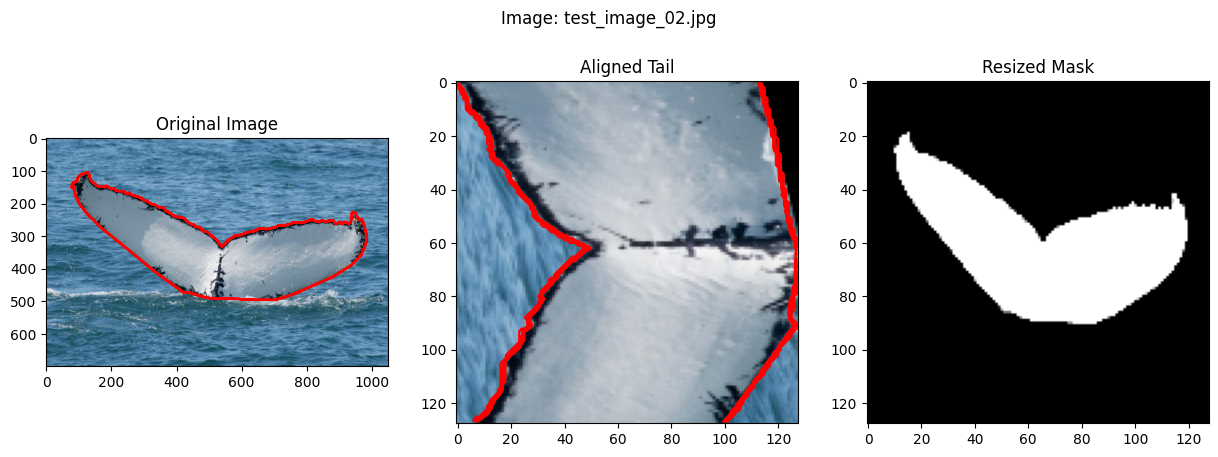

Image: test_image_01.jpg, IoU: 0.54117742987606


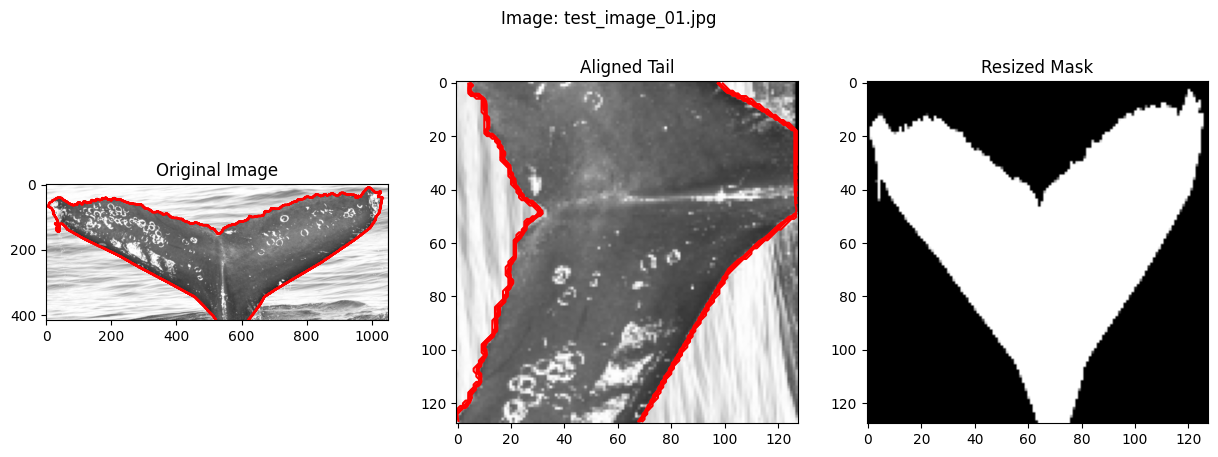

Image: test_image_08.jpg, IoU: 0.1593209780408036


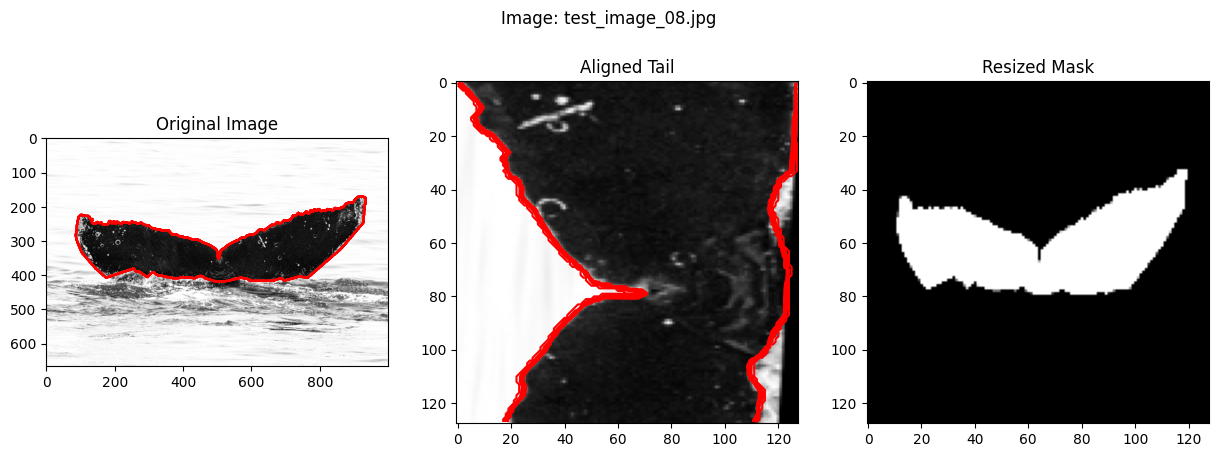

Average IoU: 0.31125505631687395


In [22]:
image_dir = 'data'
iou_scores = process_images(image_dir)
print(f'Average IoU: {np.mean(iou_scores)}')